# An Easy-to-use Notebook
This notebook will walk you through the setup, execution, and basic analysis of our HOGWILD! implementation. The notebook is written in Python3 but executes some bash scripts since our implementation is written in C. If you would like to tinker with the algorithm, you can find the iterate update function "hogwild(...)" in the repo in the file parallelized_sgd/hogwild.c. After making changes, make sure to rerun "make".

NOTE: This Notebook needs to be run on a Unix-based system in order for the bash commands to execute correctly.

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Clone and Make
Clone the repo of our C implementation of HOGWILD! to your current directory, then run "make" to build the executable from source.

In [2]:
bash_script = """
    git clone https://github.com/mstecklein/LargeScaleOptimization2_FinalProject_Hogwild.git ./Hogwild_implementation
"""

# Run script and check results
script_result = os.system(bash_script)
if script_result != 0:
    print("Script failed...")

In [3]:
bash_script = """
    cd ./Hogwild_implementation/parallelized_sgd
    make
"""

# Run script and check results
script_result = os.system(bash_script)
if script_result != 0:
    print("Script failed...")

## Generate Data
We will use a Python script from our repo to generate a data file, whose data is generated randomly from a Gaussian distribution. The data will be generated for a Linear Regression problem.

##### Input the parameters for the data to be generated:

In [4]:
num_samples = 100000
num_features = 1000
sparsity = 0.1 # between 0.0 and 1.0

Run scripts to generate data and move it to the directory of our executable.

In [5]:
bash_script = """
    cd ./Hogwild_implementation/data_generation
    python3 data_generation.py %d %d %f r data.txt
""" % (num_samples, num_features, sparsity)

# Run script and check results
script_result = os.system(bash_script)
if script_result != 0:
    print("Script failed...")
if not os.path.isfile("./Hogwild_implementation/data_generation/data.txt") or not \
       os.path.isfile("./Hogwild_implementation/data_generation/data-iterate.txt"):
    print("Data generation failed...")

In [6]:
bash_script = """
    mv ./Hogwild_implementation/data_generation/data.txt ./Hogwild_implementation/parallelized_sgd
    mv ./Hogwild_implementation/data_generation/data-iterate.txt ./Hogwild_implementation/parallelized_sgd
"""

# Run script and check results
script_result = os.system(bash_script)
if script_result != 0:
    print("Script failed...")
if not os.path.isfile("./Hogwild_implementation/parallelized_sgd/data.txt") or not \
       os.path.isfile("./Hogwild_implementation/parallelized_sgd/data-iterate.txt"):
    print("Moving data failed...")

## Run Algorithm
Run the HOGWILD! algorithm on the data generated above for Linear Regression.

##### Input the number of cores that your machine has:
The script will run the algorithm using 1,2,...,num_cores threads. Using more threads than the number of available cores will only provide degredations in speedup, but feel free to try it if you don't believe us!

In [7]:
num_cores = 4

##### Input the parameters for the algorithm
Set the desired number of total iterations (across all threads/cores) and the fixed step size to use.

In [8]:
num_total_iterations = 1000000
step_size = 0.00001

##### Run HOGWILD!
We will run the HOGWILD! algorithm num_threads times using 1,2,...,num_cores threads for each run. The program will automatically log information about the execution and write it to files in a new directory.

In [9]:
for num_threads in range(1, num_cores+1):
    bash_script = """
        cd ./Hogwild_implementation/parallelized_sgd
        ./run %d data.txt linearregression hogwild %d 20 %f
    """ % (num_threads, num_total_iterations, step_size)
    script_result = os.system(bash_script)
    if script_result != 0:
        print("Run with %d threads failed..." % num_threads)

## Analyze Data

##### L2 Distance to True Iterate vs. Execution Time
Let's plot the distance from the true iterate as a function of time for our algorithms' executions.

In [10]:
def get_iteration_data(num_cores):
    fname = "./Hogwild_implementation/parallelized_sgd/hogwild_linearregression_data/log_%dthreads.csv" % num_cores
    names = [str(i) for i in range(num_features+1)]
    df = pd.read_csv(fname, header=None, names=names).iloc[1:,:]
    times = df.iloc[:,0].astype(float).values
    df.iloc[:, 1] = df.iloc[:, 1].astype(str).str.strip().str.lstrip('[').astype(float)
    df.iloc[:, -1] = df.iloc[:, -1].astype(str).str.strip().str.rstrip(']').astype(float)
    iterates = df.iloc[:, 1:].values
    return iterates, times

def l2_norm(v1, v2):
    return sum([(e1-e2)**2 for e1,e2 in zip(v1,v2)])

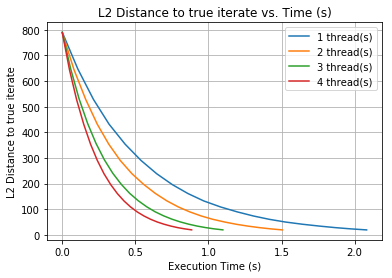

In [11]:
true_iterate = np.loadtxt(fname="./Hogwild_implementation/parallelized_sgd/data-iterate.txt", skiprows = 1)
for num_threads in range(1, num_cores+1):
    iterates, times = get_iteration_data(num_threads)
    l2_distances = [l2_norm(iterate, true_iterate) for iterate in iterates]
    plt.plot(times, l2_distances, label="%d thread(s)" % num_threads)

plt.title("L2 Distance to true iterate vs. Time (s)")
plt.xlabel("Execution Time (s)")
plt.ylabel("L2 Distance to true iterate")
plt.legend()
plt.grid()
plt.show()

##### L2 Distance to True Iterate vs. Total Iterations
Let's plot the distance from the true iterate as a function of the total number of iterations that have been completed across all threads.

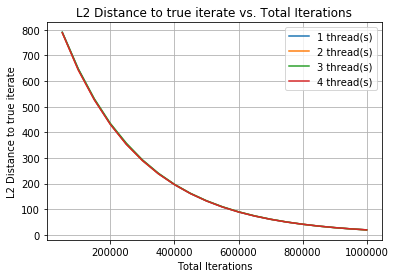

In [12]:
true_iterate = np.loadtxt(fname="./Hogwild_implementation/parallelized_sgd/data-iterate.txt", skiprows = 1)
for num_threads in range(1, num_cores+1):
    iterates, _ = get_iteration_data(num_threads)
    l2_distances = [l2_norm(iterate, true_iterate) for iterate in iterates]
    logpoint_spacing = num_total_iterations/len(iterates)
    iterations = np.linspace(logpoint_spacing, num_total_iterations, num=len(iterates))
    plt.plot(iterations, l2_distances, label="%d thread(s)" % num_threads)

plt.title("L2 Distance to true iterate vs. Total Iterations")
plt.xlabel("Total Iterations")
plt.ylabel("L2 Distance to true iterate")
plt.legend()
plt.grid()
plt.show()

##### Execution Time vs. Number of Threads
Let's plot the total execution time of the programs versus the number of threads they were run with.

In [13]:
def get_execution_time_for_cores(num_threads):
    filename = "./Hogwild_implementation/parallelized_sgd/hogwild_linearregression_data/threadstats_%dthread.csv" \
                % num_threads
    real_time = -1.0
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        header_row = next(csv_reader)
        main_row = next(csv_reader)
        real_time = float(main_row[1])
    return real_time

def get_execution_times():
    result = []
    for n in range(1, num_cores+1):
        result.append(get_execution_time_for_cores(n))
    return result

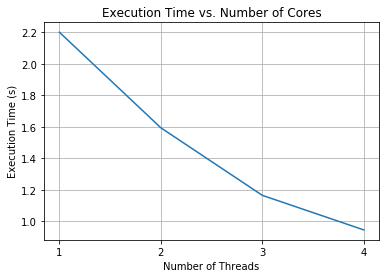

In [14]:
exe_time_vs_cores = get_execution_times()
num_threads = range(1, num_cores+1)
plt.plot(num_threads, exe_time_vs_cores)
plt.xlabel('Number of Threads')
plt.xticks(num_threads)
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Number of Cores')
plt.grid()
plt.show()

##### Speedup vs. Number of Threads

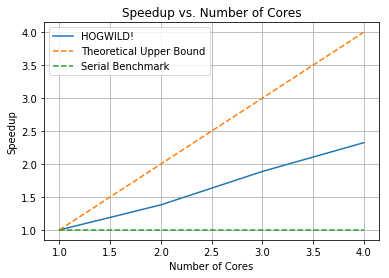

In [15]:
speedup_vs_cores = [exe_time_vs_cores[0] / t for t in exe_time_vs_cores]

plt.plot(num_threads, speedup_vs_cores, label="HOGWILD!")
plt.plot(num_threads, num_threads, label="Theoretical Upper Bound", linestyle='dashed')
plt.plot(num_threads, np.ones(len(num_threads)), label="Serial Benchmark", linestyle='dashed')
    
plt.xlabel('Number of Cores')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of Cores')
plt.legend()
plt.grid()
plt.show()